In [7]:
import pandas as pd
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.model_selection import GroupKFold
import networkx as nx
from scipy import signal

In [8]:
torch.__version__

'1.12.1+cu102'

In [9]:
from torch_geometric.data import InMemoryDataset

###
1. Dataset не должен пересекаться в train и val по пациентам
2. Выгружать датасет по нарезанным милисекундам
3. Подгружать граф связности по когерентногсти


In [ ]:
spectrums_data_path ='../../../data/MDD_EEG/preprocessing/cross_spectrum_short_pd'
main_data_path ='../../../data/MDD_EEG/raw/path_file.csv'
raw_path ='../../../data/MDD_EEG/raw/'

In [470]:
data =pd.read_csv(main_data_path)

In [471]:
data['fn_id']=data['fn'].str.split("/").apply(lambda x: x[-1][:-4])

In [472]:
slices_dataset =[]
for pack in Path(spectrums_data_path).iterdir():
    if pack.name!='.DS_Store':
        for slice1 in pack.iterdir():
            slices_dataset.append({"slice_id": pack.name +"/" +slice1.name, "fn_id": slice1.name.split("_")[0]})

In [473]:
slices_dataset=pd.DataFrame.from_records(slices_dataset)

In [474]:
full_dataset =slices_dataset.merge(data, how='right', left_on='fn_id', right_on='fn_id')

In [475]:
del full_dataset['Unnamed: 0']

In [476]:
full_dataset['start']=full_dataset['slice_id'].str.split("_").apply(lambda x : x[-1][0])

In [477]:
full_dataset

,slice_id,fn_id,fn,target,start
0,Health/S1061_0.npy,S1061,Health/S1061.csv,0,0
1,Health/F140_1.npy,F140,Health/F140.csv,0,1
2,Health/F140_2.npy,F140,Health/F140.csv,0,2
3,Health/F140_0.npy,F140,Health/F140.csv,0,0
4,Health/S512_0.npy,S512,Health/S512.csv,0,0
...,...,...,...,...,...
293,MDD/M353_2.npy,M353,MDD/M353.csv,1,2
294,MDD/M353_1.npy,M353,MDD/M353.csv,1,1
295,MDD/S1131_0.npy,S1131,MDD/S1131.csv,1,0
296,MDD/S1441_0.npy,S1441,MDD/S1441.csv,1,0


In [478]:
full_dataset

,slice_id,fn_id,fn,target,start
0,Health/S1061_0.npy,S1061,Health/S1061.csv,0,0
1,Health/F140_1.npy,F140,Health/F140.csv,0,1
2,Health/F140_2.npy,F140,Health/F140.csv,0,2
3,Health/F140_0.npy,F140,Health/F140.csv,0,0
4,Health/S512_0.npy,S512,Health/S512.csv,0,0
...,...,...,...,...,...
293,MDD/M353_2.npy,M353,MDD/M353.csv,1,2
294,MDD/M353_1.npy,M353,MDD/M353.csv,1,1
295,MDD/S1131_0.npy,S1131,MDD/S1131.csv,1,0
296,MDD/S1441_0.npy,S1441,MDD/S1441.csv,1,0


In [479]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.25, n_splits=2, random_state = 7)
split = splitter.split(full_dataset, groups=full_dataset['fn'])
train_inds, test_inds = next(split)

train = full_dataset.iloc[train_inds]
test = full_dataset.iloc[test_inds]

In [480]:
train

,slice_id,fn_id,fn,target,start
0,Health/S1061_0.npy,S1061,Health/S1061.csv,0,0
4,Health/S512_0.npy,S512,Health/S512.csv,0,0
5,Health/S1102_0.npy,S1102,Health/S1102.csv,0,0
6,Health/S472_0.npy,S472,Health/S472.csv,0,0
7,Health/S472_1.npy,S472,Health/S472.csv,0,1
...,...,...,...,...,...
293,MDD/M353_2.npy,M353,MDD/M353.csv,1,2
294,MDD/M353_1.npy,M353,MDD/M353.csv,1,1
295,MDD/S1131_0.npy,S1131,MDD/S1131.csv,1,0
296,MDD/S1441_0.npy,S1441,MDD/S1441.csv,1,0


In [481]:
train.to_csv('../../../data/MDD_EEG/preprocessing/train.csv', index=False)
test.to_csv('../../../data/MDD_EEG/preprocessing/test.csv', index=False)

In [482]:
full_dataset.to_csv('../../../data/MDD_EEG/preprocessing/slicing.csv', index=False)

In [483]:
full_dataset.iloc[0]

slice_id    Health/S1061_0.npy
fn_id                    S1061
fn            Health/S1061.csv
target                       0
start                        0
Name: 0, dtype: object

In [484]:
full_dataset.iloc[0]['slice_id']

'Health/S1061_0.npy'

In [485]:
def get_eeg_data(eeg_raw, raw_path, slice_path,slice_size =21500):
    slice_csv =slice_path / eeg_raw['slice_id']
    slice1 =pd.read_csv(slice_csv)
    file_name = raw_path / eeg_raw['fn']
    print(slice_size*int(eeg_raw['start']))
    print(slice_size*(int(eeg_raw['start'])+1))
    eeg =pd.read_csv(file_name).iloc[slice_size*int(eeg_raw['start']): slice_size*(int(eeg_raw['start'])+1), :]
    eeg =eeg.drop( columns =['Unnamed: 0', 'time'])
    return slice1, eeg

In [486]:
slice1, eeg=get_eeg_data(full_dataset.iloc[0], Path(raw_path), Path(spectrums_data_path))

0
21500


<AxesSubplot:>

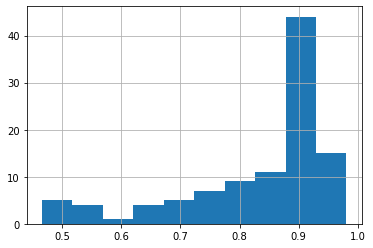

In [487]:
slice1['0'].hist()

In [488]:
columns_dict = {i : column for i, column in enumerate(eeg.columns.tolist())}
print(eeg.columns.tolist())
columns_dict_inverted ={column : i for i, column in enumerate(eeg.columns.tolist())}

['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'Cz', 'P3', 'P4', 'Pz', 'O1', 'O2', 'F7', 'F8']


In [489]:
columns_dict_inverted

{'Fp1': 0,
 'Fp2': 1,
 'F3': 2,
 'F4': 3,
 'Fz': 4,
 'C3': 5,
 'C4': 6,
 'Cz': 7,
 'P3': 8,
 'P4': 9,
 'Pz': 10,
 'O1': 11,
 'O2': 12,
 'F7': 13,
 'F8': 14}

In [490]:
band_bounds = {
    'theta' : [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 45],
    '4_6': [2, 4],
    '6_8': [2, 4],
    '8_10': [2, 4],
    '10_12': [2, 4],
}

In [491]:
def get_col_name(method, band, ch_1, ch_2=None):
    band_name = 'nofilt' if band is None else band
    s = method + '_' + band_name + '_' + ch_1
    if ch_2:
        s += '_' + ch_2
    return s

In [492]:
def get_bands_feats(df, bands=('alpha', 'beta', 'theta', 'gamma'), sfreq=500., nperseg=1024):

    channels = df.columns

    feats = {}

    for ch in channels:
        freqs, psds = signal.welch(df[ch], sfreq, nperseg=nperseg)
        psd_df = pd.DataFrame(data={'freqs': freqs, 'psds': psds})
        total = psd_df['psds'].sum()
        for band in bands:
            feats[get_col_name('bands', band, ch)] = (
                psd_df.loc[
                    (psd_df['freqs'] >= band_bounds[band][0]) &
                    (psd_df['freqs'] <= band_bounds[band][1]),
                    'psds']
                .sum()
                / total
            )
    return feats

In [493]:
def get_eeg_data(slice1, eeg,label, treshold =0.5):
    X=eeg.T.to_numpy()
    edges,edge_attrs =[], []
    for raw in slice1.iterrows():
        edge =raw[1]['Unnamed: 0'].split("_")
        edge[0]=columns_dict_inverted[edge[0]]
        edge[1]=columns_dict_inverted[edge[1]]
        edge_attr =raw[1]['0']
        if edge_attr>treshold:
            edges.append(edge.copy())
            edge_attrs.append(edge_attr)
    print(np.array(edges).T.shape)
    print(X.shape) 
    return Data(x=torch.tensor(X), edge_index=torch.tensor(np.array(edges).T), y=torch.tensor([label]))  

In [494]:
data =get_eeg_data(slice1, eeg,0.0, treshold =0.5)

(2, 101)
(15, 21500)


In [495]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
          6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,
          9,  9, 10, 10, 10, 10, 11, 11, 12, 12, 13],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  2,  3,  4,  5,
          6,  7,  8,  9, 10, 11, 12, 13, 14,  3,  4,  5,  6,  7,  8,  9, 10, 11,
         12, 13,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5,  6,  7,  8,  9,
         10, 11, 12, 13, 14,  6,  7,  8,  9, 10, 11, 12, 13, 14,  7,  8,  9, 10,
         11, 12, 13, 14,  8,  9, 10, 11, 12, 13,  9, 10, 11, 12, 13, 10, 11, 12,
         13, 14, 11, 12, 13, 14, 12, 13, 13, 14, 14]])

In [496]:
df_bands =pd.DataFrame(pd.Series(get_bands_feats(eeg))).reset_index()
df_bands["electrode"] =df_bands["index"].str.split("_").apply(lambda x :x[-1])
df_bands["band"] =df_bands["index"].str.split("_").apply(lambda x :x[-2])
df_bands=df_bands.pivot(index='band', columns ='electrode', values=0)

In [497]:
df_bands =df_bands.reindex(columns=eeg.columns)

In [498]:
df_bands

,Fp1,Fp2,F3,F4,Fz,C3,C4,Cz,P3,P4,Pz,O1,O2,F7,F8
band,,,,,,,,,,,,,,,
alpha,0.040322,0.039408,0.099649,0.082264,0.084606,0.112714,0.121336,0.118683,0.148187,0.119762,0.151377,0.151017,0.144675,0.066956,0.045921
beta,0.034586,0.040208,0.084378,0.107091,0.085927,0.081379,0.167909,0.076241,0.098026,0.116473,0.131769,0.108498,0.160600,0.056322,0.065395
gamma,0.000308,0.000600,0.001230,0.001731,0.001034,0.000898,0.002788,0.000719,0.001253,0.001502,0.001722,0.001474,0.002083,0.000515,0.001004
theta,0.126323,0.121173,0.158091,0.162541,0.177000,0.186274,0.161283,0.206378,0.169778,0.166656,0.165723,0.117658,0.146641,0.173483,0.104100


In [499]:
slice1.loc[slice1['0']>0.6]

,Unnamed: 0,0
0,Fp1_Fp2,0.852161
1,Fp1_F3,0.918149
2,Fp1_F4,0.771119
3,Fp1_Fz,0.899137
4,Fp1_C3,0.929079
...,...,...
97,Pz_F7,0.897224
99,O1_O2,0.787859
100,O1_F7,0.865120
102,O2_F7,0.871319


In [500]:
slice1.loc[slice1['Unnamed: 0']=='F4_F7']

,Unnamed: 0,0
48,F4_F7,0.715573


In [501]:
slice1.loc[slice1['Unnamed: 0']=='F4_F7']

,Unnamed: 0,0
48,F4_F7,0.715573


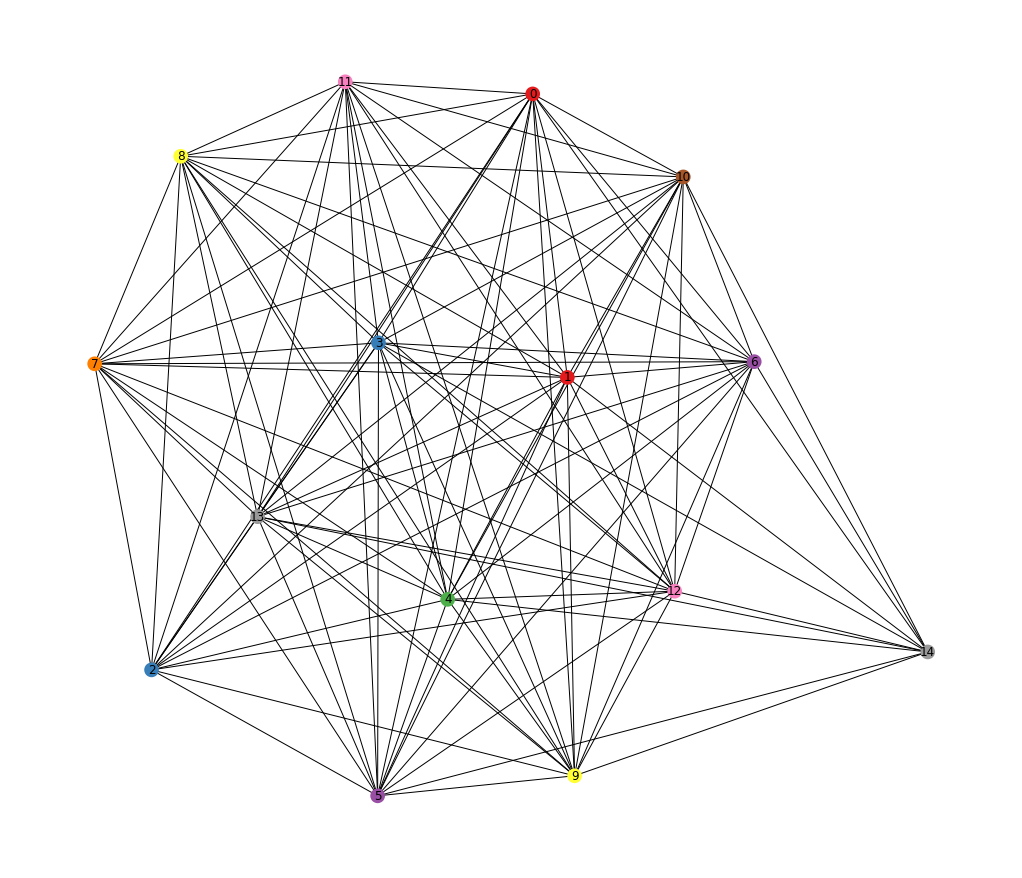

In [502]:
g = to_networkx(data, to_undirected=True)
node_labels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'Cz', 'P3', 'P4', 'Pz', 'O1', 'O2', 'F7', 'F8']
node_labels =list(range(15))
import matplotlib.pyplot as plt
plt.figure(1,figsize=(14,12)) 
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6,with_labels = True)
plt.show()

In [506]:
class GNNDataset(InMemoryDataset):
    def __init__(self, root_raw, root_spectrum,file_path,ids, transform=None, pre_transform=None):
        self.df_part1 =pd.read_csv(file_path)
        self.root_raw =root_raw
        self.root_spectrum =root_spectrum
        self.ids=ids
        super(GNNDataset, self).__init__(root_raw, transform,pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[self.ids])
    
    
    def get_eeg_dataset(self,eeg_raw, raw_path, slice_path,slice_size =21500):
        slice_csv =slice_path / eeg_raw['slice_id']
        slice1 =pd.read_csv(slice_csv)
        file_name = raw_path / eeg_raw['fn']
        eeg =pd.read_csv(file_name).iloc[slice_size*int(eeg_raw['start']): slice_size*(int(eeg_raw['start'])+1), :]
        eeg =eeg.drop( columns =['Unnamed: 0', 'time'])
        return slice1, eeg
    
    def extract_features(self,eeg):
        df_bands =pd.DataFrame(pd.Series(get_bands_feats(eeg))).reset_index()
        df_bands["electrode"] =df_bands["index"].str.split("_").apply(lambda x :x[-1])
        df_bands["band"] =df_bands["index"].str.split("_").apply(lambda x :x[-2])
        return df_bands.pivot(index='band', columns ='electrode', values=0).reindex(columns=eeg.columns)

    def get_eeg_data(self,slice1, eeg,label, treshold =0.5):
        columns_dict = {i : column for i, column in enumerate(eeg.columns.tolist())}
        columns_dict_inverted ={column : i for i, column in enumerate(eeg.columns.tolist())}
        X=self.extract_features(eeg).T.to_numpy()
        edges,edge_attrs =[], []
        for raw in slice1.iterrows():
            edge =raw[1]['Unnamed: 0'].split("_")
            edge[0]=columns_dict_inverted[edge[0]]
            edge[1]=columns_dict_inverted[edge[1]]
            edge_attr =raw[1]['0']
            if edge_attr>treshold:
                edges.append(edge.copy())
                edge_attrs.append(edge_attr)
        return Data(x=torch.tensor(X), edge_index=torch.tensor(np.array(edges).T),edge_attrs=edge_attrs, y=torch.tensor([label]))  

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['gnn_dataset_train3f_attr.pt','gnn_dataset_test3f_attr.pt']

    def download(self):
        pass
    
    def process(self):
        print('process')
        print(self.df_part1)
        data_list = []
        for ind in range(self.df_part1.shape[0]):
            slice1, eeg=self.get_eeg_dataset(self.df_part1.iloc[ind], Path(self.root_raw), Path(self.root_spectrum))
            data_exmp =self.get_eeg_data(slice1, eeg, self.df_part1.iloc[ind]['target'], 0.5)
            data_list.append(data_exmp)
            
        
        data, slices = self.collate(data_list)
        print(data)
        torch.save((data, slices), self.processed_paths[self.ids])

In [507]:
train_dataset =GNNDataset(raw_path, spectrums_data_path,'../../../data/MDD_EEG/preprocessing/train.csv', ids=0)
val_dataset =GNNDataset(raw_path, spectrums_data_path,'../../../data/MDD_EEG/preprocessing/test.csv', ids=1)

Processing...


process
               slice_id  fn_id                fn  target  start
0    Health/S1061_0.npy  S1061  Health/S1061.csv       0      0
1     Health/S512_0.npy   S512   Health/S512.csv       0      0
2    Health/S1102_0.npy  S1102  Health/S1102.csv       0      0
3     Health/S472_0.npy   S472   Health/S472.csv       0      0
4     Health/S472_1.npy   S472   Health/S472.csv       0      1
..                  ...    ...               ...     ...    ...
220      MDD/M353_2.npy   M353      MDD/M353.csv       1      2
221      MDD/M353_1.npy   M353      MDD/M353.csv       1      1
222     MDD/S1131_0.npy  S1131     MDD/S1131.csv       1      0
223     MDD/S1441_0.npy  S1441     MDD/S1441.csv       1      0
224     MDD/S1332_0.npy  S1332     MDD/S1332.csv       1      0

[225 rows x 5 columns]
Data(x=[3375, 4], edge_index=[2, 22155], y=[225], edge_attrs=[225])
process
             slice_id  fn_id               fn  target  start
0   Health/F140_1.npy   F140  Health/F140.csv       0      1
1 

Done!
Processing...


Data(x=[1095, 4], edge_index=[2, 7166], y=[73], edge_attrs=[73])


Done!


In [508]:
print()
print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')


Dataset: GNNDataset(225):
Number of graphs: 225


In [509]:
print()
print(f'Dataset: {val_dataset}:')
print('====================')
print(f'Number of graphs: {len(val_dataset)}')


Dataset: GNNDataset(73):
Number of graphs: 73


In [510]:
train_dataset = train_dataset.shuffle()

len(train_dataset)

225

In [511]:
train_dataset[0]

Data(x=[15, 4], edge_index=[2, 105], y=[1], edge_attrs=[105])

In [512]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 417], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 2:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 413], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 3:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 416], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 4:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 386], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 5:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 419], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 6:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 365], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 7:
Number of graphs in the current batch: 4
DataBatch(x=[60, 4], edge_index=[2, 410], y=[4], edge_attrs=[4], batch=[60], ptr=[5])

Step 8:
Number of graphs in the current batch: 4

In [525]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,SAGEConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(train_dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x


In [526]:
from IPython.display import Javascript

model = GCN(hidden_channels=64)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()


In [519]:
model

GCN(
  (conv1): GATv2Conv(4, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [520]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x.type(dtype=torch.float), data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x.type(dtype=torch.float), data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 002, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 003, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 004, Train Acc: 0.5378, Test Acc: 0.3973
Epoch: 005, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 006, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 007, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 008, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 009, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 010, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 011, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 012, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 013, Train Acc: 0.5200, Test Acc: 0.3973
Epoch: 014, Train Acc: 0.4889, Test Acc: 0.4795
Epoch: 015, Train Acc: 0.5556, Test Acc: 0.4110
Epoch: 016, Train Acc: 0.5556, Test Acc: 0.4110
Epoch: 017, Train Acc: 0.4800, Test Acc: 0.6027
Epoch: 018, Train Acc: 0.5289, Test Acc: 0.3973
Epoch: 019, Train Acc: 0.5378, Test Acc: 0.4110
Epoch: 020, Train Acc: 0.5689, Test Acc: 0.4521
Epoch: 021, Train Acc: 0.5378, Test Acc: